In [1]:
from pandas import read_csv, DataFrame,concat,notnull,isnull,Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import fsolve
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
data=read_csv("output_and_def_oct28.csv")
data.index=data['scenario_number']
flooded=read_csv("people_flooded.csv")
flooded.index=flooded['scenario_number']
flooded=flooded.drop('scenario_number',axis=1)

data.rename(columns={'PARLIAMENT BRIDGE 3(150.0000)':'PARLIAMENT', 'KOTTE ELA NORTH(0.0000)':'KOTTE', 
                     'KIRILLAPONE2(771.0500)':'KIRILLAPONE2', 'PARLIAMENT_UPPER_REACH(1803.5500)':'PARLIAMENT_UPPER_REACH', 
         'TALANGAMA(3416.0000)':'TALANGAMA', 'KIRILLAPONE2(1388.0300)':'KIRILLAPONE22', 'TORRINGTON CNL(81.6800)':'TORRINGTON', 
         'TORRINGTON_B01(33.0600)':'TORRINGTON_B01', 'MAHAWATTA TO HEEN ELA(349.6500)':'MAHAWATTA', 
         'MAHAWATTA ELA(49.9900)':'MAHAWATTA2', 'WELLAWATTA CNL(0.0000)':'WELLAWATTA', 'DEMATAGODA ELA(0.0000)':'DEMATAGODA', 
         'DEMATAGODA ELA 2(3414.8899)':'DEMATAGODA2', 'ST. SEBASTIAN NORTH CANAL(1400.8700)':'SEBASTIAN2',
         'ST. SEBASTIAN SOUTH CANAL(-75.0000)':'SEBASTIAN3', 'MAIN DRAIN(1094.8000)':'MAIN',
         'DEHIWARA CNL(1003.8000)':'DEHIWARA', 'KIRILLAPONE3(2156.1499)':'KIRILLAPONE3',
         'KIRILLAPONE2(934.0800)':'KIRILLAPONE23', 'TORRINGTON_B01(33.0600).1':'TORRINGTON_B012',
         'SERPENTINE(40.0000)':'SERPENTINE', 'ST.SEBASTIAN_SOUTH_DIVERSION(200.0000)':'SEBASTIAN_SOUTH_DIVERSION', 
         'ST. SEBASTIAN SOUTH CANAL(1025.1801)':'SEBASTIAN', 'MAIN DRAIN(1177.1600)':'MAIN2'}, inplace=True)


Selects only 2 cross sections

In [3]:
varin1='PARLIAMENT'
varin2='SEBASTIAN'
subdata=data[[varin1, varin2, 'return_period','wetland_loss','climate_change','runoff','bndconditions','scenario_number']]
subdata=concat([subdata,flooded],axis=1)
subdata.rename(columns={'Estimated Population Exposed using GN method': 'Pop','share of Total Population using A2'
                        : 'share'}, inplace=True)

## calculates losses

In [4]:
pop_multiplier=2.8*0.3

In [5]:
def calccost(pop_exposed,gdp_gr,gdp_per_capita_2013,pop_multiplier):
    cost=pop_exposed*gdp_per_capita_2013*(1+gdp_gr)**(2040-2013)*pop_multiplier
    return cost


In [6]:
#GDP per capita 2013 in constant lkr
gdp_per_capita_2013=160*10**3
gdp_per_capita_2010=128*10**3

In [7]:
subdata.ix[notnull(subdata['share']),'cost']=calccost(subdata.ix[notnull(subdata['share']),'Pop'],0,gdp_per_capita_2013,pop_multiplier)
subdata.ix[notnull(subdata['share']),'costlog']=np.log(subdata.ix[notnull(subdata['share']),'cost'])


## predicts missing water level data points

In [8]:
formula=varin1+" ~ return_period + wetland_loss + climate_change + runoff  + bndconditions"
olsmodel=sm.ols(formula,data=subdata).fit()

In [9]:
predictions=olsmodel.predict(subdata)
subdata.loc[subdata[varin1].isnull().values,varin1]=predictions[subdata[varin1].isnull().values]

In [10]:
formula=varin2+" ~ return_period + wetland_loss + climate_change + runoff  + bndconditions"
olsmodel2=sm.ols(formula,data=subdata).fit()
res2=olsmodel2.params
predictions2=olsmodel2.predict(subdata)
subdata.loc[subdata[varin2].isnull().values,varin2]=predictions2[subdata[varin2].isnull().values]

## predicts damages based on a few points using water level

In [11]:
subdata['logPARLIAMENT']=np.log(subdata['PARLIAMENT'])
subdata['logSEBASTIAN']=np.log(subdata['SEBASTIAN'])

In [12]:
formula="costlog ~ logPARLIAMENT"
damagemodel=sm.ols(formula,data=subdata).fit()

In [13]:
predicted_damages=damagemodel.predict(subdata)
subdata.loc[subdata['costlog'].isnull().values,'costlog']=predicted_damages[subdata['costlog'].isnull().values]
subdata['costestimated']=np.exp(subdata['costlog'])

In [14]:
nb_people_exposed=0.8*10**6
R=gdp_per_capita_2013*nb_people_exposed

In [15]:
def event_damage_distrib(x):
    cost=x.ix[:,['return_period','costestimated']].copy()
    s = InterpolatedUnivariateSpline(cost['return_period'], cost['costestimated'], k=1)
    zerocost=DataFrame({'return_period':[1,100,200,10000],'costestimated':[0,s(100),s(200),s(200)]})
    cost=concat([zerocost,cost])
    cost.sort(columns='return_period', inplace=True)
    cost.index=range(len(cost))
    cost['costestimated']=cost['costestimated'].astype(float)
    f = InterpolatedUnivariateSpline(cost['return_period'], cost['costestimated'], k=1)
    events=np.linspace(0.000001,1,num=500)
    damages = f(1/events)
    return damages

In [16]:
charac_col=['wetland_loss','climate_change','runoff','bndconditions']
annloss=subdata.groupby(charac_col).apply(lambda x:event_damage_distrib(x))

In [17]:
charac=subdata.groupby(charac_col).apply(lambda x:x[charac_col].head(1))
scenar=subdata.groupby(charac_col).apply(lambda x:x['scenario_number'].head(1))

In [18]:
new_data=concat([scenar,charac],axis=1)
new_data.index=range(len(new_data))
annloss.index=range(len(annloss))

In [19]:
new_data['annuallosses']=annloss

In [20]:
new_data

,scenario_number,wetland_loss,climate_change,runoff,bndconditions,annuallosses
0,1,0,0,0.4,0,"[43217436669.3, 43217436669.3, 43217436669.3, ..."
1,2,0,0,0.4,1,"[46431651840.0, 46431651840.0, 46431651840.0, ..."
2,5,0,0,0.5,0,"[44363517850.5, 44363517850.5, 44363517850.5, ..."
3,6,0,0,0.5,1,"[50383906005.0, 50383906005.0, 50383906005.0, ..."
4,3,0,0,0.6,0,"[45989348910.6, 45989348910.6, 45989348910.6, ..."
5,4,0,0,0.6,1,"[53689067440.6, 53689067440.6, 53689067440.6, ..."
6,7,0,1,0.4,0,"[54628588126.6, 54628588126.6, 54628588126.6, ..."
7,8,0,1,0.4,1,"[66274538131.3, 66274538131.3, 66274538131.3, ..."
8,11,0,1,0.5,0,"[58829406627.7, 58829406627.7, 58829406627.7, ..."
9,12,0,1,0.5,1,"[70843553800.5, 70843553800.5, 70843553800.5, ..."


In [21]:
losses_wetlands=DataFrame()
for wetland_loss in new_data['wetland_loss'].unique():
    select=new_data['wetland_loss']==wetland_loss
    out=[]
    for i in new_data[select].index:
        out=np.concatenate([out,new_data.ix[i,'annuallosses']])
    losses_wetlands['{}wetlandloss'.format(wetland_loss)]=out

In [22]:
losses_wetlands

,0wetlandloss,10wetlandloss,50wetlandloss,70wetlandloss,100wetlandloss
0,4.321744e+10,4.385943e+10,4.882894e+10,9.130356e+10,6.542999e+10
1,4.321744e+10,4.385943e+10,4.882894e+10,9.130356e+10,6.542999e+10
2,4.321744e+10,4.385943e+10,4.882894e+10,9.130356e+10,6.542999e+10
3,3.704880e+10,3.763336e+10,4.196100e+10,7.627048e+10,5.609803e+10
4,2.943804e+10,2.995175e+10,3.348746e+10,5.772293e+10,4.458441e+10
5,2.487129e+10,2.534247e+10,2.840299e+10,4.659366e+10,3.767578e+10
6,2.182666e+10,2.226950e+10,2.501321e+10,3.917383e+10,3.306983e+10
7,1.965186e+10,2.007445e+10,2.259187e+10,3.387381e+10,2.977978e+10
8,1.802072e+10,1.842813e+10,2.077582e+10,2.989871e+10,2.731219e+10
9,1.675205e+10,1.714764e+10,1.936332e+10,2.680691e+10,2.539292e+10


In [55]:
%matplotlib inline

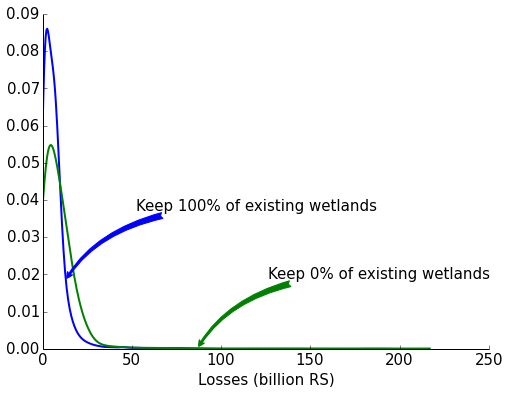

In [58]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)

density = gaussian_kde(losses_wetlands['0wetlandloss']/10**9)
xs = np.linspace(0,max(losses_wetlands['100wetlandloss'])/10**9,num=500)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='blue')
plt.annotate('Keep 100% of existing wetlands', xy=(xs[30], density(xs[30])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='blue', ec='blue',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )

density = gaussian_kde(losses_wetlands['100wetlandloss']/10**9)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),linewidth=2,color='green')
plt.annotate('Keep 0% of existing wetlands', xy=(xs[200], density(xs[200])),  xycoords='data',
                    xytext=(70, 70), textcoords='offset points',
                    size=15,
                    #bbox=dict(boxstyle="round", fc="0.8"),
                    arrowprops=dict(arrowstyle="fancy",
                                    fc='green', ec='green',
                                    patchB=None,
                                    connectionstyle="angle3,angleA=0,angleB=60"),
                        )
plt.xlabel('Losses (billion RS)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('all_losses_per_wetland_loss.png',bbox_inches="tight",dpi=500)